# 导入相关的package

In [64]:
# 基础的package
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import os
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

# 模型相关的package
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

### 画图全局设置

In [65]:
plt.rcParams['figure.figsize'] = (20,5)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.axisbelow'] = True
colors = ['#44A948', '#137CB1', '#EACC80', '#A8D7E2', '#E58061']

# 数据相关的函数

### 计算收益率的文件，希望是一个字典，然后每个品种对应一个DataFrame,纵轴是时间，横轴是收益率，收益率为一分钟，五分钟和十分钟，二十分钟以及一个小时。

### 计算因子，然后滞后一分钟，因为害怕出现未来函数

### 刚开始最主要的是判断出，那天是期权的行权日, 然后进行分段的处理

### 如果可以的话，希望可以预测三个模型，因为希望可以对极端行情有更好的适应性

### 读取数据并去除重复行

### 读取期权快照数据

In [66]:
# 读取未经过处理的数据，需要判断行权日以及空缺值，还需要观察形态
def get_snapshot():
    snapshot = pd.read_csv('./csv/market.csv',index_col = None, header = None)
    snapshot.columns = ['kind','datetime','open','high','low','close','vol']
    snapshot.drop_duplicates(inplace=True)
    snapshot.reset_index(drop=True,inplace=True)
    return snapshot

### 读取逐笔成交数据

In [67]:
def get_tick():
    tick = pd.read_csv('./csv/depth.csv',index_col = None, header = None)
    tick.columns = ['amount', 'price', 'datetime', 'type', 'kind']
    tick.drop_duplicates(inplace=True)
    tick.reset_index(drop=True,inplace=True)
    return tick

### 读取现货数据

In [73]:
def get_spot():
    spot = pd.read_csv('./csv/spot.csv',index_col = None,header = None)
    spot.columns = ['datetime', 'kind', 'open', 'high', 'low', 'close', 'vol']
    spot.drop_duplicates(inplace=True)
    spot.reset_index(drop=True,inplace=True)
    return spot

### 期权 填充时间轴

In [74]:
def get_digit_opt_continue(digit_name, snapshot):
    y = snapshot[snapshot['kind'] == digit_name]
    y = y.groupby('datetime').tail(1).set_index('datetime')

    timeline = pd.date_range(y.index[0], y.index[-1], freq = '1min')
    timeline = list(map(str, timeline))

    _timeline = []
    for i in timeline:
        if i not in y.index:
            _timeline.append(i)

    _y = pd.DataFrame(
        [[digit_name,np.nan,np.nan,np.nan,np.nan,np.nan]]*len(_timeline),
        index = _timeline,
        columns=y.columns,
    )

    y = pd.concat([_y,y]).sort_index()
    return y

### 获得某一个种类的现货数据

In [75]:
def get_digit(name,spot):
    return  spot[spot.kind == name]

### 判断行权日（不精确）

In [76]:
def get_strike_day(opt):
    st = opt.apply(lambda x:(np.isnan(x.close)) and (x.name[-8:-6]=='16'),axis = 1)
    st = st[st]
    st.index = st.index.map(lambda x:x[:10])
    st = st.groupby(st.index).sum()

    ans = st[st == 60].index.tolist()
    return ans

In [77]:
%%time
snapshot = get_snapshot()
tick = get_tick()
spot = get_spot()

Wall time: 2min 51s


In [78]:
# 暂时主要是快照的数据来构造特征，所以先对快照数据进行清洗以及填充
# 2020-03-18 23:31 有异常值，都3000了，应该去除，或者采用open填充,发现这些异常值都集中在market0_552_1中
# 所以可以先不考虑这个品种
print(snapshot.shape)
print(tick.shape)
print(spot.shape)

(9053680, 7)
(5383951, 5)
(26561891, 7)


In [79]:
for i in np.sort(snapshot.kind.drop_duplicates().values):
    print(i, end = " | ")

market0_472_1 | market0_473_1 | market0_486_1 | market0_487_1 | market0_490_1 | market0_491_1 | market0_514_1 | market0_515_1 | market0_516_1 | market0_517_1 | market0_518_1 | market0_519_1 | market0_522_1 | market0_523_1 | market0_526_1 | market0_527_1 | market0_530_1 | market0_531_1 | market0_532_1 | market0_533_1 | market0_541_1 | market0_542_1 | market0_544_1 | market0_545_1 | market0_546_1 | market0_547_1 | market0_548_1 | market0_549_1 | market0_551_1 | market0_552_1 | 

In [80]:
%%time
digit_name_c0 = 'market0_486_1'
digit_name_p0 = 'market0_487_1'
digit_name_c1 = 'market0_516_1'
digit_name_p1 = 'market0_517_1'

c0 = get_digit_opt_continue(digit_name_c0,snapshot)
p0 = get_digit_opt_continue(digit_name_p0,snapshot)
c1 = get_digit_opt_continue(digit_name_c1,snapshot)
p1 = get_digit_opt_continue(digit_name_p1,snapshot)
y = get_digit('BTCP', spot)

Wall time: 11.6 s


In [81]:
%%time
print(get_strike_day(c0))
print(get_strike_day(p0))
print(get_strike_day(c1))
print(get_strike_day(p1))

['2020-03-18', '2020-04-22', '2020-05-20']
['2020-03-18', '2020-04-22', '2020-05-20']
['2020-03-04', '2020-04-08', '2020-05-06']
['2020-03-04', '2020-04-08', '2020-05-06']
Wall time: 15 s


### 分段画出期权的图像

In [19]:
# 画图
def plot_opt(y,ans):
    start,end = ' 17:00:00', ' 15:59:00'
    for i in range(len(ans)):
        if i == 0:
            y.loc[:ans[0] + end,'close'].plot(figsize = (20,5),color = colors[4])
            plt.show()
        else:
            y.loc[ans[i-1] + start:ans[i] + end, 'close'].plot(figsize = (20,5),color = colors[4])
            plt.show()
        if i == len(ans) - 1:
            y.loc[ans[len(ans)-1] + start:,'close'].plot(figsize = (20,5),color = colors[4])
            plt.show()

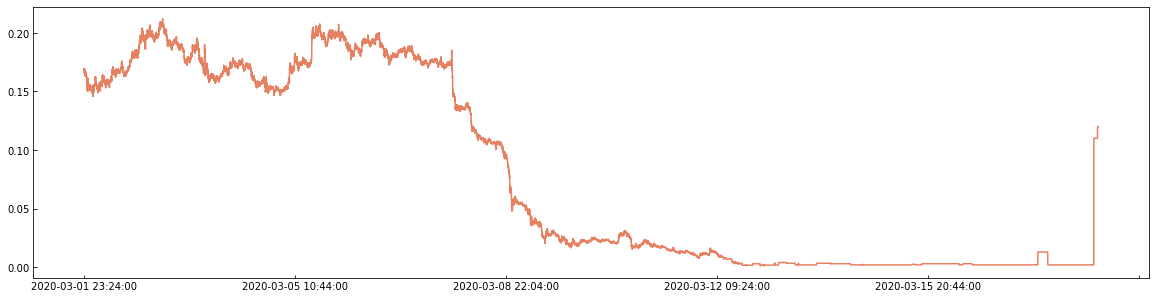

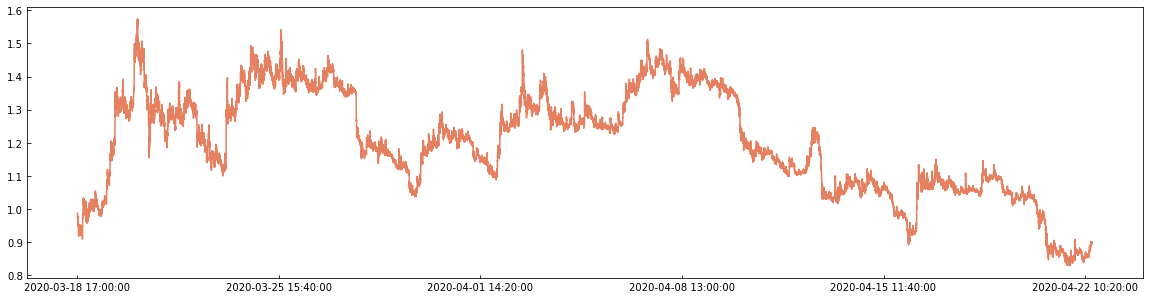

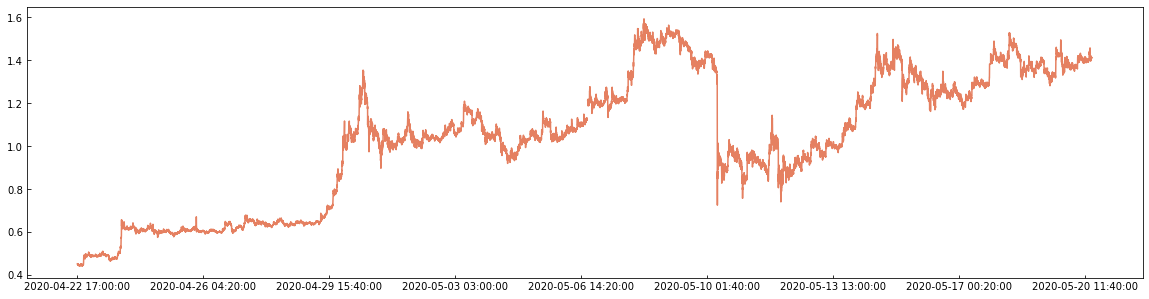

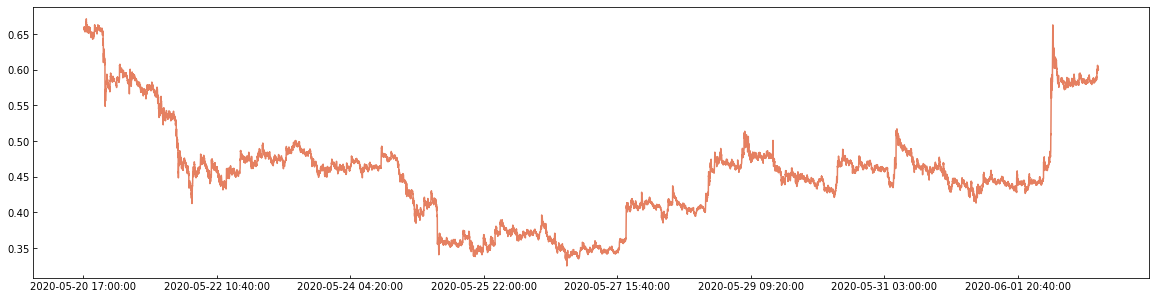

In [46]:
plot_opt(c0, get_strike_day(c0))

In [35]:
%%time
# 查找所有期权的
for i in np.sort(snapshot.kind.drop_duplicates().values):
    opt = get_digit_opt_continue(i,snapshot)
    ans = get_strike_day(opt)
    print('\n','======== ',i,' =======',end = '\n\n')
    start,end = ' 17:00:00', ' 15:59:00'
    print(ans)


 ========  market0_472_1  =======

['2020-03-16', '2020-04-20', '2020-05-18']

 ========  market0_473_1  =======

['2020-03-16', '2020-04-20', '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-18']

 ========  market0_486_1  =======

['2020-03-18', '2020-04-22', '2020-05-20']

 ========  market0_487_1  =======

['2020-03-18', '2020-04-22', '2020-05-20']

 ========  market0_490_1  =======

['2020-03-19', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-23', '2020-05-21']

 ========  market0_491_1  =======

['2020-03-19', '2020-04-23', '2020-05-07', '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-12', '2020-05-21']

 ========  market0_514_1  =======

['2020-03-04', '2020-03-11', '2020-03-18', '2020-03-25', '2020-04-01', '2020-04-08', '2020-04-15', '2020-04-22', '2020-04-29', '2020-05-06', '2020-05-13', '2020-05-20', '2020-05-27']

 ========  market0_515_1  =======

['2020-03-04', '2020-03-11', '2020-03-18', '2020-03-25', '202

### 计算因子，滞后一分钟

In [41]:
get_strike_day(c0)

['2020-03-18', '2020-04-22', '2020-05-20']

In [83]:
y.datetime = y.datetime.apply(lambda x:x[:4]+ '-' + x[4:6] + '-' + x[6:8] + x[8:] + ':00')
y.set_index('datetime', inplace = True)

In [108]:
def f(x):
    if x>=0.002:
        return 1
    elif x<=-0.002:
        return -1
    else:
        return 0

In [ ]:
%%time
# ret = -np.log(y.close).diff(-10)
end = ' 16:00:00'
start = ' 17:00:00'

position = []
long_windows = 60
short_windows = 10
timepoint = get_strike_day(c0)
for i in range(3):
    if i == 2:
        _y = y.loc[timepoint[i]+start:]
        _c0 = c0.loc[timepoint[i]+start:]
        _p0 = p0.loc[timepoint[i]+start:]
    else:
        _y = y.loc[timepoint[i]+start: timepoint[i+1]+end]
        _c0 = c0.loc[timepoint[i]+start: timepoint[i+1]+end]
        _p0 = p0.loc[timepoint[i]+start: timepoint[i+1]+end]
    
    ret = -np.log(_c0.close).diff(-10)
    
    fac0 = np.log(_y.close).diff(long_windows)
    fac1 = np.log(_y.close).diff(short_windows)
    fac2 = np.log(_y.close).diff().rolling(long_windows).std()
    fac3 = np.log(_y.close).diff().rolling(short_windows).std()
    fac4 = ((_y.high - _y.low) / (_y.close + _y.open)).rolling(long_windows).mean()
    fac5 = ((_y.high - _y.low) / (_y.close + _y.open)).rolling(short_windows).mean()
    fac6 = _y.vol.rolling(long_windows).sum()
    fac7 = _y.vol.rolling(short_windows).sum()
    
    fac8 = np.log(_c0.close).diff(long_windows)
    fac9 = np.log(_c0.close).diff(short_windows)
    fac10 = np.log(_c0.close).diff().rolling(long_windows).std()
    fac11 = np.log(_c0.close).diff().rolling(short_windows).std()
    fac12 = ((_c0.high - _c0.low) / (_c0.close + _c0.open)).rolling(long_windows).mean()
    fac13 = ((_c0.high - _c0.low) / (_c0.close + _c0.open)).rolling(short_windows).mean()
    fac14 = _c0.vol.rolling(long_windows).sum()
    fac15 = _c0.vol.rolling(short_windows).sum()
    
    fac16 = np.log(_p0.close).diff(long_windows)
    fac17 = np.log(_p0.close).diff(short_windows)
    fac18 = np.log(_p0.close).diff().rolling(long_windows).std()
    fac19 = np.log(_p0.close).diff().rolling(short_windows).std()
    fac20 = ((_p0.high - _p0.low) / (_p0.close + _p0.open)).rolling(long_windows).mean()
    fac21 = ((_p0.high - _p0.low) / (_p0.close + _p0.open)).rolling(short_windows).mean()
    fac22 = _p0.vol.rolling(long_windows).sum()
    fac23 = _p0.vol.rolling(short_windows).sum()
    
    fac24 = (_c0.vol - _p0.vol) / (_c0.vol+_p0.vol+1).rolling(long_windows).mean()
    fac25 = (_c0.close.diff()) / (_y.close.diff()).rolling(long_windows).mean()
    fac26 = (_p0.close.diff()) / (_y.close.diff()).rolling(long_windows).mean()
    
    columns = ['fac{}'.format(i) for i in range(27)]
    factors = pd.concat(
        [fac0,fac1,fac2,fac3,fac4,fac5,fac6,fac7,fac8,fac9,fac10,fac11,fac12,fac13,fac14,fac15,fac16,fac17,fac18,fac19,fac20,fac21,fac22,fac23,fac24,fac25,fac26],
        axis = 1,
    )
    factors.columns = columns
    
    factors = factors.shift()
    
    for _i in range(1440, _y.shape[0]-120):
        X_train, Y_train =  factors.iloc[_i-1440:_i,:].fillna(0), ret.iloc[_i-1440:_i].fillna(0).apply(f)
        X_test, Y_test = factors.iloc[_i:_i+1,:].fillna(0), ret.iloc[_i:_i+1].fillna(0).apply(f)
        model = XGBClassifier(n_jobs = 7)
        r = model.fit(X_train, Y_train)
        prey = r.predict(X_test)
#         print(Y_test.iloc[0], ' ', prey[0])
        position.append(prey[0])
            
    pos = np.array(position)
    a = ret[1440:]
    net = [[0.1] * 10]
    for ii in range(0, len(pos)//10):
        n = []
        for j in range(10):
            n.append(net[-1][j] * (1+pos[10*ii+j] * a[10*ii+j]))
        net.append(n)
        
    print(i)
    fig,ax = plt.subplots()
    ax.plot(np.array(net).sum(axis = 1))
    plt.show(fig)

## 实验

In [126]:
pos = np.array(position)
a = ret[1440:]
net = [[0.1] * 10]
for i in range(0, len(pos)//10):
    n = []
    for j in range(10):
        _ = net[-1][j] * (1+pos[10*i+j] * a[10*i+j])
        if (i!=0) & (pos[10*i+j] != pos[10*i+j-10]):
            _ = _ * 0.998
        n.append(_)
    net.append(n)

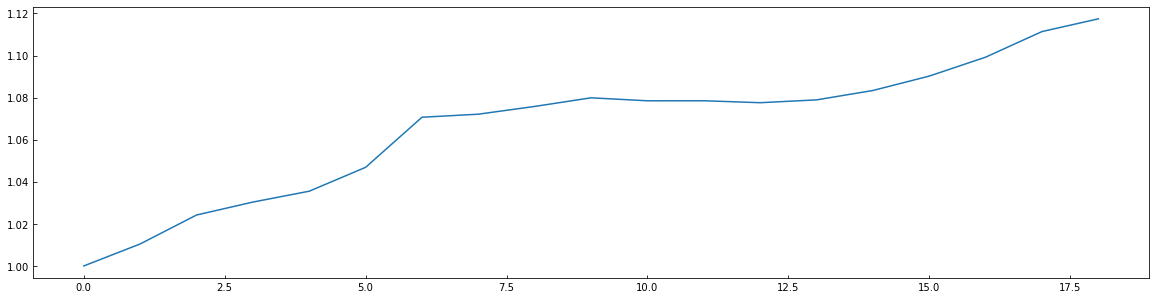

In [127]:
plt.plot(np.array(net).sum(axis = 1))

In [132]:
net

[[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]]

In [133]:
pos

array([-1, -1, -1], dtype=int64)